In [60]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

In [61]:
# 导入数据
mnist = input_data.read_data_sets("mnist_data")
img = mnist.train.images[50]

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [62]:
# 模型输入
def get_inputs(real_size, noise_size):
#实际图像和随机噪声
    real_img = tf.placeholder(tf.float32, [None, real_size], name="real_img")
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name="noise_img")
    return real_img, noise_img

In [63]:
#生成器
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    with tf.variable_scope("generator", reuse=reuse):
        hidden1 = tf.layers.dense(noise_img, n_units)  # 全连接层
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        return logits, outputs

In [86]:
#判别器
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    with tf.variable_scope("discriminator", reuse=reuse):
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        return logits, outputs

In [87]:
#超参
img_size = mnist.train.images[0].shape[0]
noise_size = 100
g_units = 128
d_units = 128
alpha = 0.01 # Leak factor
learning_rate = 0.001
smooth = 0.1

In [88]:
#搭建模型
tf.reset_default_graph()
real_img, noise_img = get_inputs(img_size, noise_size)
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)
#判别器
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)
#计算loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_real, labels=tf.ones_like(d_logits_real)
) * (1 - smooth))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)
))
d_loss = tf.add(d_loss_real, d_loss_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
) * (1 - smooth))
# 获取相应要训练的变量
train_vars = tf.trainable_variables()
g_vars = [var for var in train_vars if var.name.startswith("generator")]
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

In [89]:
#优化器 
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [90]:
#训练参数
epochs = 5000
samples = []
n_sample = 10
losses = []

In [91]:
# 把MNISt数据中标签为0的图像提取出来，存到列表里
i = j = 0
while i<5000:
    if mnist.train.labels[j] == 2:
        samples.append(mnist.train.images[j])
        i += 1
    j += 1

print(len(samples))
size = samples[0].size


5000


784


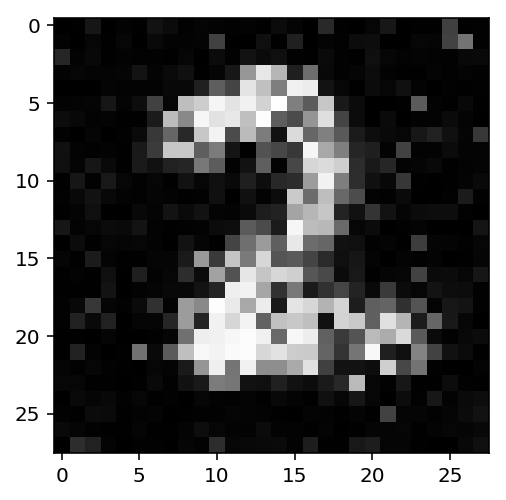

In [92]:
with tf.Session() as sess:
#    初始化参数
    tf.global_variables_initializer().run()
    for e in range(epochs):
        batch_images = samples[e] * 2 -1
        batch_noise = np.random.uniform(-1, 1, size=noise_size)
 
        _ = sess.run(d_train_opt, feed_dict={real_img:[batch_images], noise_img:[batch_noise]})
        _ = sess.run(g_train_opt, feed_dict={noise_img:[batch_noise]})
 
    sample_noise = np.random.uniform(-1, 1, size=noise_size)
    g_logit, g_output = sess.run(get_generator(noise_img, g_units, img_size,
                                         reuse=True), feed_dict={
        noise_img:[sample_noise]
    })
    print(g_logit.size)
    g_output = (g_output+1)/2
    plt.imshow(g_output.reshape([28, 28]), cmap='Greys_r')
    plt.show()